In [1]:
import sympy as sp
def getMetric(lineElement, coordSystem="Cartesian", subs=None, overrideConst = False): #the override lets the code run faster if you know for sure your line element will work out
    if coordSystem not in ["Cartesian", "PlanePolar", "SphericalPolar", "CylindricalPolar"]:
        raise ValueError("Unknown coordinate system")

    lineElement=sp.expand(lineElement)
    coords = (t, x, y, z)

    dim = len(coords)
    g = sp.zeros(dim)
    T = sp.zeros(dim)
    for mu in range(dim):
        for nu in range(dim):
            coeff = lineElement.coeff(sp.diff(coords[mu]) * sp.diff(coords[nu]))
            if mu != nu and coeff != 0:
                g[mu, nu] = coeff.subs(subs) / 2
                T[mu, nu] = coeff/2
            else:
                g[mu, nu] = coeff.subs(subs)
                T[mu, nu] = coeff
    display(T)
                
    # Check for unexpected terms in the line element
    if not overrideConst:
        reconstructed_line_element = sum(g[i, j] * sp.diff(coords[i]) * sp.diff(coords[j]) for i in range(dim) for j in range(dim))
        if sp.simplify(lineElement.subs(subs) - reconstructed_line_element) != 0:
            raise ValueError("Line element contains terms that are not pure differentials of the coordinates used")
    return g

In [9]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the symbolic variables
vs, sigma, R, lam = sp.symbols('v_s sigma R lambda')
xs, r, f_r, c = sp.symbols("x_s r f_r c")

t = sp.Function('t')(lam)
x = sp.Function('x')(lam)
y = sp.Function('y')(lam)
z = sp.Function('z')(lam)
dt=sp.diff(t)
dx=sp.diff(x)
dy=sp.diff(y)
dz=sp.diff(z)

# Constants
const_t = 0
const_z = 0
const_sigma = 5
const_R = 1
const_c = 1
const_vs = 0.9

# Define the differential and symbolic expression for gamma_22
# lineElement = (
#     (((f_r-1)**2*vs**2-1)/(1-vs**2))*c**2*dt**2
#     + ((2*f_r*vs*((f_r-1)*vs**2-1))/(1-vs**2))*c*dt*dx
#     + ((1+vs**2*(f_r*(f_r*vs**2-2)-1))/(1-vs**2))*dx**2
#     + dy**2
#     + dz**2
# )


lineElement= -c**2*dt**2+(dx-vs*f_r*c*dt)**2+dy**2+dz**2
display(lineElement)
subs = [
    (f_r, (sp.tanh(sigma * (r + R)) - sp.tanh(sigma * (r - R))) / (2 * sp.tanh(sigma * R))),
    (r, sp.sqrt((x - xs)**2 + y**2 + z**2)),
#     (xs, nu*(x-vs*c*t)), #THIS LINE IS A POSSIBLE SOURCE OF ERROR
    (xs, vs*t), #THIS LINE IS A POSSIBLE SOURCE OF ERROR
#     (nu, 1/sp.sqrt(1-vs**2)),
    (dt, 1),  # Assuming t, x, y, z vary linearly
    (dx, 1),
    (dy, 1),
    (dz, 0),
    (t, const_t),
    (z, const_z),
    (sigma, const_sigma),
    (R, const_R),
    (c, const_c),
#     (vs, const_vs)
]


-c**2*Derivative(t(lambda), lambda)**2 + (-c*f_r*v_s*Derivative(t(lambda), lambda) + Derivative(x(lambda), lambda))**2 + Derivative(y(lambda), lambda)**2 + Derivative(z(lambda), lambda)**2

In [10]:

# Applying substitutions
# simplified_line_element = lineElement.subs(subs)
metric = getMetric(lineElement, "Cartesian", subs, True)
display(metric)
gamma_22_expr = sp.sqrt(-metric.det()) * (metric.inv()[2, 2] / metric[0, 0])


Matrix([
[c**2*f_r**2*v_s**2 - c**2, -c*f_r*v_s, 0, 0],
[               -c*f_r*v_s,          1, 0, 0],
[                        0,          0, 1, 0],
[                        0,          0, 0, 1]])

Matrix([
[v_s**2*(-tanh(5*sqrt(x(lambda)**2 + y(lambda)**2) - 5) + tanh(5*sqrt(x(lambda)**2 + y(lambda)**2) + 5))**2/(4*tanh(5)**2) - 1, -v_s*(-tanh(5*sqrt(x(lambda)**2 + y(lambda)**2) - 5) + tanh(5*sqrt(x(lambda)**2 + y(lambda)**2) + 5))/(2*tanh(5)), 0, 0],
[            -v_s*(-tanh(5*sqrt(x(lambda)**2 + y(lambda)**2) - 5) + tanh(5*sqrt(x(lambda)**2 + y(lambda)**2) + 5))/(2*tanh(5)),                                                                                                                 1, 0, 0],
[                                                                                                                            0,                                                                                                                 0, 1, 0],
[                                                                                                                            0,                                                                                                                 0

In [19]:

# Simplify gamma_22_expr to speed up lambdification
gamma_22_expr = sp.simplify(gamma_22_expr)

# Lambdify the expression
gamma_22_func = sp.lambdify((x, y, vs), gamma_22_expr, "numpy")

a=10
# Generate a grid and compute values
x_values = np.linspace(-a, a, 200)
y_values = np.linspace(-a, a, 200)
X, Y = np.meshgrid(x_values, y_values)
Gamma_22 = gamma_22_func(X, Y, 0.3)

In [12]:
gamma_22_expr

4*tanh(5)**2/(v_s**2*(tanh(5*sqrt(x(lambda)**2 + y(lambda)**2) - 5) - tanh(5*sqrt(x(lambda)**2 + y(lambda)**2) + 5))**2 - 4*tanh(5)**2)

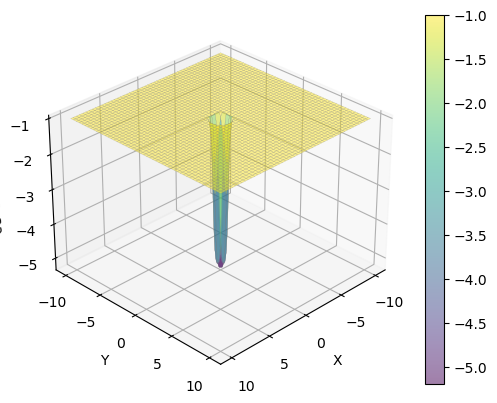

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Gamma_22, cmap='viridis', edgecolor='gray', linewidth=0.1, alpha=0.5, shade=True)
fig.colorbar(surf)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Gamma_22')

# Adjust the view angle for better aesthetic
ax.view_init(elev=30, azim=45)  # elevation and azimuth

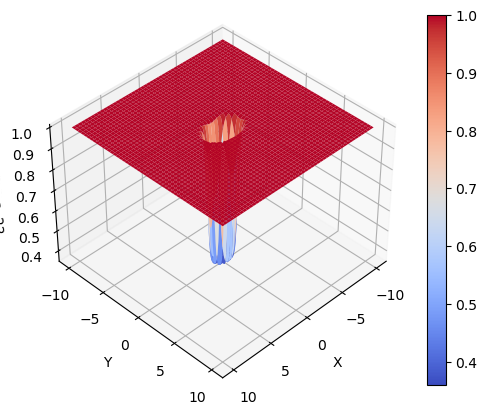

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Gamma_22, cmap='coolwarm', edgecolor='none', alpha=1)  # Changed cmap and alpha
fig.colorbar(surf)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Gamma_22')

ax.view_init(elev=40, azim=45)  # Changed view angles for better perspective


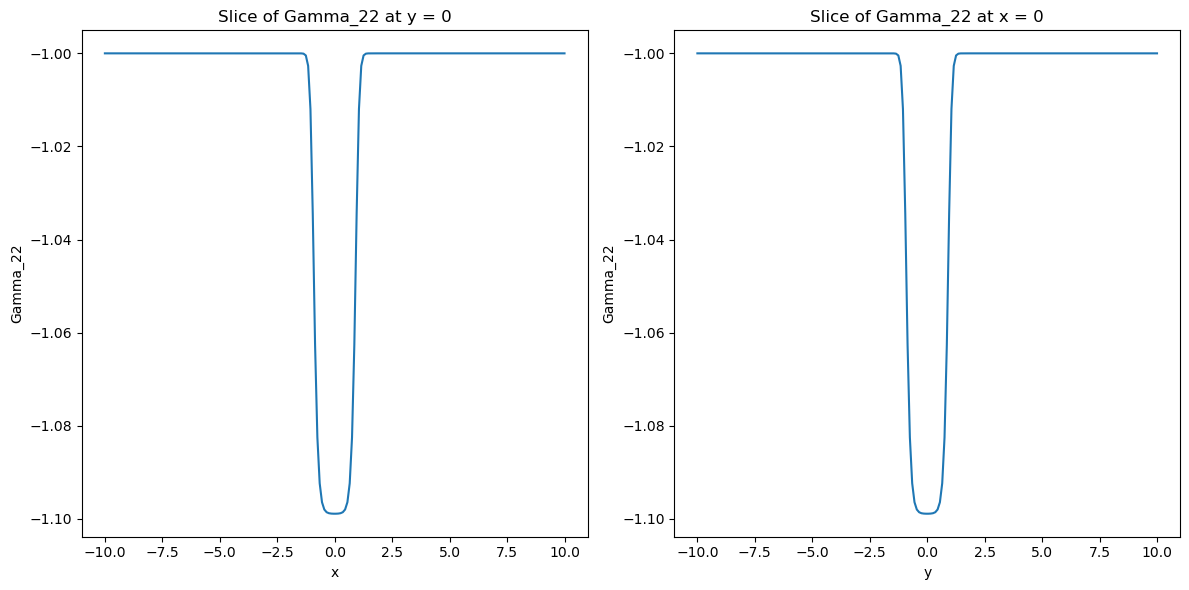

In [20]:
# Assuming Gamma_22, X, and Y are defined and computed as before
# Indices where x=0 and y=0 (assuming they are included in the linspace from -10 to 10)
# idx_x0 = np.where(X[0] == 0)[0][0]  # Index for x = 0
# idx_y0 = np.where(Y[:, 0] == 0)[0][0]  # Index for y = 0
idx_x0 = int(len(X)/2)
idx_y0 = int(len(Y)/2)

# Extracting slices
gamma_x0 = Gamma_22[idx_y0, :]  # Gamma_22 slice at y = 0
gamma_y0 = Gamma_22[:, idx_x0]  # Gamma_22 slice at x = 0

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Two plots side by side

# Plot for x slice at y=0
axs[0].plot(X[0, :], gamma_x0)
axs[0].set_title('Slice of Gamma_22 at y = 0')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Gamma_22')

# Plot for y slice at x=0
axs[1].plot(Y[:, 0], gamma_y0)
axs[1].set_title('Slice of Gamma_22 at x = 0')
axs[1].set_xlabel('y')
axs[1].set_ylabel('Gamma_22')

plt.tight_layout()
plt.show()


In [7]:
Gamma_22[0][0]

nan